In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# %load Makefile
# %load Makefile
#############################################################
######
# Makefile for project 2
# Laurence Brown
# SMU Mathematics
# Math 3316
# 9/28/2015
#############################################################
######
# compiler & flags
CXX = g++
CXXFLAGS = -O -std=c++0x
# makefile targets
#newton_test.exe	:	newton.cpp	test_newton.cpp
#linear_solve.exe	:	matrix.cpp	vandermonde.cpp		
#kepler.exe	:	matrix.cpp	newton.cpp	kepler.cpp

all:
	$(CXX) $(CXXFLAGS) newton.cpp test_newton.cpp -o test_newton.exe
	$(CXX) $(CXXFLAGS) matrix.cpp	vandermonde.cpp -o linear_solve.exe
	$(CXX) $(CXXFLAGS) matrix.cpp	newton.cpp kepler.cpp -o kepler.exe
	
	chmod 755 test_newton.exe
	chmod 755 linear_solve.exe
	chmod 755 kepler.exe

clean :
	rm -f *.exe *.txt
####### End of Makefile #######


# Linear Solver

## Gaussian Elimination with Scaled Partial Pivoting

Bellow is my code for a Matrix Library with a Linear Solver. The solver is tested on Vandermode Matrices ($V_{i,j} = \alpha^{j-1}_i $) of diffrent sizes, $n = {5, 9, 17, 33, 65} $. After the system $Ax = b$ is solved for $\tilde{x}$ error and resiual vector are calculated. 

$$ e = x - \tilde{x} $$
$$ r = Ae $$

The output of the program is the 2-Norm of each vector for every trial.

$$ \abs{\abs{e}}^2 $$
$$ \abs{\abs{r}}^2 $$

In [8]:
# %load matrix.cpp
#include "matrix.h"
#include <cmath> /* pow */
#include <algorithm> /* max */
#include <random>
#include <iostream>

// singularity tolerance
#define STOL 1.e-15

using namespace std;

/*
	Basic Vector Functions
*/

//create a new vector of linearly space data
vector<double> Linspace(double a, double b, int n){
	if (n<2) cerr << "Linspace::length must be > 1\n";
	vector<double> v(n);
	
	double h = (b-a)/(n-1);
	for (int i=0; i<n; i++)
	 	v[i] = a + i*h;

	return v;
}

//entry wise multiplication of vectors
vector<double> times(vector<double> a, vector<double> b){
	if (a.size() != b.size()) cerr << "times::two vectors must be of same length\n";
	vector<double> c;
	for (int i=0; i<a.size(); i++)
		c.push_back(a[i] * b[i]);
	return c;
}

//matrix scaler
vector<double> scale(vector<double> v, double s){
	vector<double> result;
	for (int i=0; i<v.size(); i++)
		result.push_back(v[i] * s);
	return result;
}

//add vectors element wise
std::vector<double> add(std::vector<double> a, std::vector<double> b){
	if (a.size() != b.size()) cerr << "add::two vectors must be of same length\n";
	vector<double> c;
	for (int i=0; i<a.size(); i++)
		c.push_back(a[i] + b[i]);
	return c;
}
//add vectors element wise
std::vector<double> sub(std::vector<double> a, std::vector<double> b){
	if (a.size() != b.size()) cerr << "sub::two vectors must be of same length\n";
	vector<double> c;
	for (int i=0; i<a.size(); i++)
		c.push_back(a[i] - b[i]);
	return c;
}


//colapse vector to double, (sum entries)
double sum_vector(vector<double> v){
	double  sum = 0;
	for (int i=0; i<v.size(); i++)
		sum += v[i];
	return sum;
}

//computes the p norm of a vector
double norm(vector<double> v, int p){
	return pow(abs(sum_vector(v)),p);
}


//raise each element to a power n in a vector
vector<double> vector_pow(vector<double> v, double n){
	vector<double> result;
	for (int i=0; i<v.size(); i++)
		result.push_back(pow(v[i],n));
	return result;
}

//generate random vector
vector<double> random(int n){
	//uniform distribution
	std::default_random_engine generator;
	std::uniform_real_distribution<double> distribution(0,100);			//uniform real double distribution
	vector<double> v;
	for (int i=0; i<n; i++)
		v.push_back(distribution(generator));  							//generates number in the range(0...100)
	return v;
}

//returns max element index
int max_index(vector<double> v){
	int mx = 0;
	for (int i=1; i<v.size(); i++){
		if (v[i] > v[mx])
			mx = i;
	}
	return mx;
}

//reverses vector in place
void reverse(std::vector<double> & v){
	vector<double> tmp;

	for (int i=v.size()-1; i>=0; i--)
		tmp.push_back(v[i]);

	v = tmp;
}

//swap vector elements in place
void swap(vector<double> & v, int a, int b){
	double tmp = v[a];
	v[a] = v[b];
	v[b] = tmp;
}

//print vector
void print_vector(vector<double> v){
	for (int i=0; i<v.size(); i++)
		cout << v[i] << " ";
}

//write a vector to a file
int write(std::vector<double> v, const char *outfile) { 

  // open output file
  FILE *fptr = NULL;
  fptr = fopen(outfile, "w");
  if (fptr == NULL) {
    cerr << "Write:: error, unable to open " << outfile << " for writing\n";
    return 1;
  }

  // print data to file
  for (size_t i=0; i<v.size(); i++) {
      fprintf(fptr, "  %.16g", v[i]);
  }

  // close output file and return
  fclose(fptr);
  return 0;
}


/*

	Matrix Class Member Functions

*/

//constructors
Matrix::Matrix(){
	ncol = 1;
	nrow = 1;
	vector<double> tmp;
	M.push_back(tmp);
}

Matrix::Matrix(int r, int c){
	ncol = c;
	nrow = r;

	for (int i=0; i<c; i++){
		vector<double> tmp(r);
		M.push_back(tmp);
	}
}

Matrix::Matrix(vector<double> v){
	ncol = 1;
	nrow = v.size();
	M.push_back(v);
}

Matrix::Matrix(const Matrix & rhs){
	ncol = rhs.ncol;
	nrow = rhs.nrow;
	M = rhs.M;
}


//assigment operators
Matrix& Matrix::operator= (const Matrix & rhs){

    if (this != &rhs) // protect against invalid self-assignment
    {
    	nrow = rhs.nrow;
    	ncol = rhs.ncol;
    	M = rhs.M;
    }
    // by convention, always return *this
    return *this;
}

Matrix& Matrix::operator= (const vector<double> & rhs){
	nrow = rhs.size();
	ncol = 1;
	M[0] = rhs;

	return *this;
}

//access operators
double Matrix::operator() (int i, int j){return M[i][j];}

//return column vector
vector<double> Matrix::operator() (int i){return M[i];}

//make it an Identity of col/row size n
void Matrix::Identity_Matrix(int n){

	//create matrix of correct dimensions
	Matrix I(n,n);
	M = I.M;
	nrow = n;
	ncol = n;

	//fill diagnols with '1''s
	for(int i=0; i<ncol; i++)
		M[i][i] = 1;
}

//make it a Vandermonde
void Matrix::Vandermonde_Matrix(vector<double> v, int c){

	//clear
	M.clear();

	nrow = v.size();
	ncol = c;

	//create a Vandermonde Matrix from first column vector v
	M.push_back(v);

	//create all remaining columns
	for (int i=2; i<ncol+2; i++){
		vector<double> p = vector_pow(v, i);
		M.push_back(p);
	}
}

//clear matrix
void Matrix::clear(){
	vector<vector<double> > clr;
	M = clr;
	nrow = 0;
	ncol = 0;
}

//transpose of matrix
void Matrix::T(){
	Matrix R;
	R.clear();

	for (int r=0; r<nrow; r++)
	{
		vector<double> new_col;
		for(int c=0; c<ncol; c++){
			new_col.push_back(M[c][r]);
		}
		R.M.push_back(new_col);
	}

	int tmp = ncol;
	ncol = nrow;
	nrow = tmp;
	M = R.M;
}


//vector matrix multiplication
//Matrix Matrix::dot(vector<double> v){
vector<double> Matrix::dot(vector<double> v){

	//for each entry in the vector multiply it by corresponding column in matrix
	Matrix R(nrow, v.size());

	//scale matrix by vector entries
	for (int i=0; i<v.size(); i++){
		R.M[i] = scale(M[i], v[i]);
	}

	//collapse standing matrix (sum columns)
	//1 transpose matrix
	R.T();

	//collanpse column vectors
	vector<double> tmp;
	for(int i=0; i<ncol; i++){
		tmp.push_back(sum_vector(R.M[i]));
	}

	return tmp;
}

//Matrix Matrix multiplication
Matrix Matrix::dot(Matrix B){

	//exit condition
	if (this->ncol != B.nrow) cerr << "Matrix::dot two Matrices must be of correct dim.\n";
	
	Matrix C(this->nrow, B.ncol);

	//perform Matrix Matrix multiplication
	//perform vector matrix multiplication for each row of B (T() col), storing results in C
	//B.T();
	for (int i=0; i<B.ncol; i++)
		C.M[i] = this->dot(B.M[i]);

	return C;
}

/*
	elementary row operations
*/
//swap, swap row a with row b
void Matrix::swap_rows(int a, int b){
	if (a >= nrow || b >= nrow || a < 0 || b < 0)cerr << "error: Matrix::swap_rows - Indicies of matrix must be valid.\n";
	this->T();
	vector<double> tmp = M[a];
	M[a] = M[b];
	M[b] = tmp;
	this->T();
}

//scale, scale row r by constant c
void Matrix::scale_row(int r, double c){
	this->T();
	M[r] = scale(M[r],c);
	this->T();
}

//add, add row a to row b
void Matrix::add_row(int a, int b){
	this->T();
	M[b] = add(M[a], M[b]);
	this->T();
}

//add row with factor, add row a to b with factor or c
void Matrix::add_scaled_row(int a, int b, double c){
	this->T();
	M[b] = add( scale(M[a], c), M[b] );
	this->T();
}

//eliminate leading non zero value in row b with some scaled value of row a
void Matrix::eliminate_lead_non0(int a, int b){

	this->T();

	//find leading non0 term in row b
	int col = -1;
	for (int i=0; i< M[b].size(); i++){
		if (M[b][i] != 0){
			col = i;
			break;
		}
	}
	if (col != -1){
		double c = M[b][col] / M[a][col];
		this->T();
		this->add_scaled_row(a,b,-c);
		this->T();
	}
	this->T();
}

//eliminate col value in row b with some scaled value of row a, returns scaler c
double Matrix::eliminate_0(int a, int b, int col){

		if(M[col][b] != 0 && M[col][a] != 0){
			double c = -(M[col][b] / M[col][a]);
			this->add_scaled_row(a,b,c);
			return c;
		}
		
		return 1;
}

// LU and P Factorization, 
int Matrix::LUP_factorization(Matrix &L, Matrix &U, Matrix &P){
	if (this->nrow != this->ncol)	cerr << "(error) Matrix::LUP_factorization::Matrix mustbe square\n";

	//lower triangluar matrix base (set as identity matrix)
	L.Identity_Matrix(this->nrow);


	//upper triangular Matrix base (set this Matrix as starting place)
	U.nrow = this->nrow;
	U.ncol = this->ncol;
	U.M = this->M;

	// P matrix to keep track of row swaps (and scales?) (set identity matrix)
	P.Identity_Matrix(this->nrow);

	// perform Gaussian elimination for LU factorization
	for (int k=0; k<U.nrow -1; k++) {   // loop over diagonals

		//The error comes from row swapping 
		
		//PIVOT
		// find the pivot row p (max of col) //starting from row k down

		int p=k;
		for (int i=k; i<U.nrow; i++){
		  if( abs(U.M[k][i]) >  abs(U.M[k][p]) )
			p=i;
		}

		//swap L U and P rows around the pivot
		//U
		U.swap_rows(p,k);

		//P
		P.swap_rows(p,k);
		

		//ELIMINATION
		//Perform eliminations using row k
		double c;	//scaler
		for (int i=k; i<U.nrow-1; i++){
			c = U.eliminate_0(k, i+1, k);

			if (c == 1)
				L.M[k][i+1] =  0;
			else
				L.M[k][i+1] = -c;
		}

	}


	return 0;
}


vector<double> Matrix::solve(vector<double> b){
	if (this->nrow != b.size())	cerr << "Matrix::solve::Matrix A and vector b must be of apropriate dim\n";
	if (this->nrow != this->ncol) cerr << "Matrix::solve::Matrix must be square\n";
	
	vector<double> x;

	/*
		Theorem (PA = LU;  Factorization with Pivoting).  Given that A is nonsingular.  The solution x to the linear system  Ax = b, is found in four steps:  

	    1.  Construct the matrices  L, U and P.  
	    2.  Compute the column vector  Pb.
	    3.  Solve  Ly = Pb for  y  using forward substitution.
	    4.  Solve  Ux = y for x  using back substitution.

	    -note y = Ux
	*/

	//create lower triangluar matrix base (create identity matrix)
	Matrix L;

	//create upper triangular Matrix to save A
	Matrix U;

	//create P matrix to keep track of row swaps (create identity matrix)
	Matrix P;

	this->LUP_factorization(L,U,P);

	//2.  Compute the column vector  Pb.
	vector<double> Pb = P.dot(b);

	//3.  Solve  Ly = Pb for  y  using forward substitution.	(incorrect)
	vector<double> y = L.forward_substitution(Pb);

	//4.  Solve  Ux = y for x  using back substitution.
	x = U.back_substitution(y);

	return x;
}

//back substitution (solving Ux =b)
std::vector<double> Matrix::back_substitution(std::vector<double> b){
	
	//check for correct dimensions
	if (this->nrow != b.size() || this->nrow != this->ncol){
		cerr << "Matrix::back_substitution error, illegal matrix/vector dimensions\n";
		return vector<double>(0);
	}

  // copy b into x
  vector<double> x = b;

  // analyze matrix for magnitude
  double Umax = inifinity_norm();

  // perform column-oriented Backward Substitution algorithm
  for (int j=this->nrow-1; j>=0; j--) {

    // check for nonzero matrix diagonal
    if (abs(this->M[j][j]) < STOL*Umax) {
      cerr << "BackSubstitution error: numerically singular matrix\n";
      return vector<double>(0);
    }

    // solve for this row of solution
    x[j] /= this->M[j][j];

    // update all remaining rhs
    for (int i=this->ncol; i>=j; i--){
    	int iter =(this->ncol)-(j+1);
      	x[iter] -= this->M[j][i]*x[j];
    }
  }

  return x;
}

//forward substitution (solving Lx =b)
std::vector<double> Matrix::forward_substitution(std::vector<double> b){
	
	//exit condition
	if (this->nrow != b.size()) {
		cerr << "Matrix::forward_substitution error, illegal matrix/vector dimensions\n";
		return vector<double>(0);	
	}

	// copy b into x
	vector<double> x = b;

	// analyze matrix for magnitude
	double Lmax = inifinity_norm();

	// perform column-oriented Forwards Substitution algorithm
	for (int j=0; j<this->nrow; j++) {

		// check for nonzero matrix diagonal
	    if (abs(this->M[j][j]) < STOL*Lmax) {
			cerr << "ForwardSubstitution error: singular matrix\n";
			return vector<double>(0);
		}

		// solve for this row of solution
		x[j] /= this->M[j][j];

		// update all remaining rhs
		for (int i=j+1; i<this->nrow; i++)
			x[j] -= this->M[j][i]*x[i];
	}

	return x;
}

//infinity norm (max sum of rows)
double Matrix::inifinity_norm(){
	vector<double> sums;
	this->T();
	for (int i=0; i<this->ncol; i++)
		sums.push_back(sum_vector(this->M[i]));
	this->T();

	return sums[max_index(sums)];
}

//return the index of the maximum element in the column
int Matrix::col_max_index(int col){return max_index(this->M[col]);}

void Matrix::print(){
	for (int r=0; r<nrow; r++){
		for (int c=0; c<ncol; c++){
			cout<< M[c][r] << "\t";
		}
		cout << endl;
	}
}

SyntaxError: invalid syntax (<ipython-input-8-93e26d3915b1>, line 3)

In [ ]:
# %load vandermonde.cpp
#include "matrix.h"
#include <vector>
#include <stdlib.h> /* abs */
#include <cmath> /* pow */
#include <iostream>
#include <random>

using namespace std;

//main function
int main(){

	vector<double> ns = {5, 9, 17, 33, 65};
	vector<double> e_2norm;		//e = x - xhat
	vector<double> r_2norm; 	//r = Axhat -b, Ae = r

	vector<double> e;
	vector<double> r;
	int n;
	for (int i=0; i<ns.size(); i++){

		//create Vandermonde matrix of size nxn
		n = ns[i];
		vector<double> v = Linspace(0,1,n);

		Matrix M(n,n);
		M.Vandermonde_Matrix(v,n);

		//create random vector x
		vector<double> x = random(n);

		//solve for b
		vector<double> b = M.dot(x);


		//linear solve
		vector<double> computed_x = M.solve(b);

		//calculate error vector
		e = sub(x, computed_x);
		e_2norm.push_back(norm(e, 2));

		//calculate residual vector
		vector<double> r = M.dot(e);
		r_2norm.push_back(norm(r, 2));

	}

	//write vectors, 2-norm(residual) 2-norm(error)
	//write(e_2norm, "e_2norm.txt");
	//write(r_2norm, "r_2norm.txt");

	return 0;
}	

## Deriving newtons' method from point slope form:

Point Slope Form is $ y_1 - y_2 = m ( x_1 - x_2 ) $.

Newtons' Method Formula is $ x_n = x_{n-1} - \frac {f(x_{n-1})}{f'(x_{n-1})} $.

$y_1 = 0$, when solving for a root.
$$ y_1 - y_2 = m ( x_1 - x_2 ) $$

$$ - f(x_2) = f'(x_2)(x_1 - x_2)$$

$$ - \frac {f(x_2)}{f'(x_2)} = x_1 - x_2 $$

$$ x_2 - \frac {f(x_2)}{f'(x_2)} = x_1 $$

$$ x_n = x_{n-1} - \frac {f(x_{n-1})}{f'(x_{n-1})} $$

Newtons method was implimented in the file bellow, and was tested on the function $f(x) = x^2(x−3)(x+2) = 0$ with and initial guesses $x_0 = {−3, 1, 2}$ and tolerances of $ ε = {10^{−1}, 10^{−5}, 10^{−9}} $.

In [ ]:
# %load newton.cpp
#include <cmath> /* abs */
#include <functional> /* function type */
#include <iostream>

using namespace std;

double newton(function<double(double)> func, function<double(double)> dfunc, double x, int maxit, double tol, bool show_iterates){

	//display
	if(show_iterates){
		cout << "x0 = " << x << " , tolerence = " << tol << endl;
		cout << "iteration | current guess | residual" << endl;
	}

	//intial guess
	double xn = x;
	double xn_1 = x;
	for(int i=1; i <= maxit; i++)
	{

		//Newton Method Formula
		//xn_1 = xn - (func(xn))/(dfunc(xn));
		double h = func(xn)/dfunc(xn);
		xn_1 = xn - h;

		//check if current guess is within tolernce range
		//double residual = abs(xn-xn_1);
		double residual = abs(h);

		//display
		if(show_iterates)
			cout << endl << "\t" << i << "\t"<< xn_1 << "\t"<< residual << endl;

		//break condition
		if (residual < tol){
		  cout << "\n" << "success, root found at x = " << xn_1 << endl <<endl; 	//display root
		  //return 0.0;
		  return xn_1;
		}

		//update
		double tmp = xn_1;
		xn = tmp;
	}

	cerr << "error, no convergence." <<endl << endl;			//no convergence
	
	//return 0;
	return xn_1;	//if no converges should not return this value then***

}


In [ ]:
# %load test_newton_terminal_output.txt
LJs-MacBook:project_2 ljbrown$ ./test_newton.exe 
x0 = -3 , tolerence = 0.1
iteration | current guess | residual

	1	-2.45455	0.545455

	2	-2.14186	0.312681

	3	-2.01957	0.122291

	4	-2.00045	0.0191283

success, root found at x = -2.00045

x0 = -3 , tolerence = 1e-05
iteration | current guess | residual

	1	-2.45455	0.545455

	2	-2.14186	0.312681

	3	-2.01957	0.122291

	4	-2.00045	0.0191283

	5	-2	0.000445134

	6	-2	2.37853e-07

success, root found at x = -2

x0 = -3 , tolerence = 1e-09
iteration | current guess | residual

	1	-2.45455	0.545455

	2	-2.14186	0.312681

	3	-2.01957	0.122291

	4	-2.00045	0.0191283

	5	-2	0.000445134

	6	-2	2.37853e-07

	7	-2	6.79456e-14

success, root found at x = -2

x0 = 1 , tolerence = 0.1
iteration | current guess | residual

	1	0.454545	0.545455

	2	0.228022	0.226524

	3	0.115144	0.112877

	4	0.0579873	0.0571571

success, root found at x = 0.0579873

x0 = 1 , tolerence = 1e-05
iteration | current guess | residual

	1	0.454545	0.545455

	2	0.228022	0.226524

	3	0.115144	0.112877

	4	0.0579873	0.0571571

	5	0.0291159	0.0288714

	6	0.014591	0.0145249

	7	0.00730406	0.0072869

	8	0.00365422	0.00364985

	9	0.00182766	0.00182656

	10	0.000913969	0.000913692

	11	0.000457019	0.00045695

	12	0.000228518	0.000228501

	13	0.000114261	0.000114257

	14	5.71312e-05	5.71301e-05

	15	2.85657e-05	2.85655e-05

	16	1.42829e-05	1.42828e-05

	17	7.14146e-06	7.14144e-06

success, root found at x = 7.14146e-06

x0 = 1 , tolerence = 1e-09
iteration | current guess | residual

	1	0.454545	0.545455

	2	0.228022	0.226524

	3	0.115144	0.112877

	4	0.0579873	0.0571571

	5	0.0291159	0.0288714

	6	0.014591	0.0145249

	7	0.00730406	0.0072869

	8	0.00365422	0.00364985

	9	0.00182766	0.00182656

	10	0.000913969	0.000913692

	11	0.000457019	0.00045695

	12	0.000228518	0.000228501

	13	0.000114261	0.000114257

	14	5.71312e-05	5.71301e-05

	15	2.85657e-05	2.85655e-05

	16	1.42829e-05	1.42828e-05

	17	7.14146e-06	7.14144e-06

	18	3.57073e-06	3.57073e-06

	19	1.78537e-06	1.78537e-06

	20	8.92684e-07	8.92683e-07

	21	4.46342e-07	4.46342e-07

	22	2.23171e-07	2.23171e-07

	23	1.11585e-07	1.11585e-07

	24	5.57927e-08	5.57927e-08

	25	2.78964e-08	2.78964e-08

	26	1.39482e-08	1.39482e-08

	27	6.97409e-09	6.97409e-09

	28	3.48705e-09	3.48705e-09

	29	1.74352e-09	1.74352e-09

	30	8.71761e-10	8.71761e-10

success, root found at x = 8.71761e-10

x0 = 2 , tolerence = 0.1
iteration | current guess | residual

	1	-2	4

	2	-2	0

success, root found at x = -2

x0 = 2 , tolerence = 1e-05
iteration | current guess | residual

	1	-2	4

	2	-2	0

success, root found at x = -2

x0 = 2 , tolerence = 1e-09
iteration | current guess | residual

	1	-2	4

	2	-2	0

success, root found at x = -2

LJs-MacBook:project_2 ljbrown$ 


Newton method defined above sucsessfully found roots near -2, 0, and 3.

## Keplers Equation

Kepler’s equation is $ \epsilon sin(\omega) - \omega = t $, where $ \epsilon = \sqrt{1 - \frac {b^2}{a^2}} $.

Nonlinear root-finding residual function is $ f(\omega) = \epsilon sin(\omega) - \omega -t $,

with a derivitive of $f'(\omega) = \epsilon cos(\omega)- 1 $.


The file bellow uses newton's method to solve keplers equation for $\omega(t)$ (above), each solve uses a tolerance of $10^{−5}$, with a maximum of 6 Newton iterations.
where $ a = 2, b = 1.25 $.
The intial guess is $x_1 = 0$.
Where $ t = {0, 0.001, . . . , 10} $.

Computing the Cartesian coordinates of the object,

$ x(t) = r cos(\omega) $ and 
$ y(t) = r sin(\omega) $

$$ r(\omega) = \frac {ab} { \sqrt{b cos(\omega)^2 + a sin(\omega)^2} } $$
$$ x(t) = \frac {ab} { \sqrt{b cos(\omega)^2 + a sin(\omega)^2} } * cos(\omega) $$
$$ y(t) = \frac {ab} { \sqrt{b cos(\omega)^2 + a sin(\omega)^2} } * sin(\omega) $$

In [4]:
# %load kepler.cpp
/*
	--------------------------------------------------

	equation for eleptical orbit catersian coordinates:

	x = a * sin(theta);
	y = b * cos(theta);			//or sin(theta - Pi/2);

	if(a == b): eleptical orbit;

	(scaler streches graph vertically, elongating wave.)
	(shifting the phase compresses orbit (when x and y are == we get a horizonal line from -1 to 1))
	(adding a constant define the the center point of the elispse)

	--------------------------------------------------
*/

#include <functional>	//must compile with -std=c++11
#include <iostream>
#include <vector>
#include <math.h>       /* sin, pow, sqrt */

#include "newton.h"		/* newton */
#include "matrix.h"		/* Linspace */

using namespace std;

//residual function
double kepler(double t, double e, double x){return (e * sin(x)) -x -t;}

//derivitive of residual function
double dkepler(double e, double x){return (e * cos(x));}

int main(){

	//settings for kepler's equation - kepler(t, e, x)
	double a = 2.0;
	double b = 1.25;
	double epsilon = sqrt(1 - (pow(b,2)/pow(a,2)));

	//settings for newton's method - newton(f, df, x, mi, tol, show)
	double xn = 0;
	int max_iter = 6;				//6
	double tolerance = pow(10,-5);	//-5
	bool show_iterate = false;

	//times {0, 0.001, . . . , 10}
	vector<double> ts = Linspace(0,10,10000);

	//vector of omegas corresponding to ts
	vector<double> ws;


	//run trials for all values of t
	double t;
	for (int i=0; i<ts.size(); i++){
		t = ts[i];

		//bind std::ref of t and e to the functions, use ref to pass by refrence
		const auto f = std::bind(&kepler, ref(t), ref(epsilon), std::placeholders::_1);
		const auto df = std::bind(&dkepler, ref(epsilon), std::placeholders::_1);

		//call newton
		ws.push_back(newton(f, df, xn, max_iter, tolerance, show_iterate));
		
		//the intial guess for each subsequent solve should be the returned value w
		xn = ws[i];
	}

	//x and y radial coordiantes coorispondint to omega/t
	vector<double> xs;
	vector<double> ys;

	//radial coordinates
	double rx;
	double ry;
	double r;
	for (int i=0; i<ws.size(); i++){
		r = (a*b) / (sqrt( pow(b * cos(ws[i]),2) + pow(a * sin(ws[i]),2) ));
		
		rx =  r * cos(ws[i]);
		xs.push_back(rx);

		ry = r * sin(ws[i]);
		ys.push_back(ry);
	}

	//write vectos ts, xs, ys, and ws
	write(ts, "t.txt");
	write(ws, "w.txt");
	write(xs, "x.txt");
	write(ys, "y.txt");

	return 0;
}


IndentationError: unexpected indent (<ipython-input-4-9602641a851a>, line 3)

In [3]:
t = loadtxt('t.txt')
w = loadtxt('w.txt')
x = loadtxt('x.txt')
y = loadtxt('y.txt')

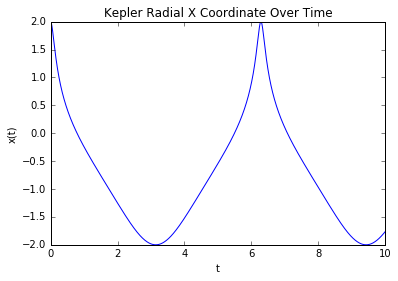

In [4]:
plot(t,x)
xlabel('t')
ylabel('x(t)')
title('Kepler Radial X Coordinate Over Time')

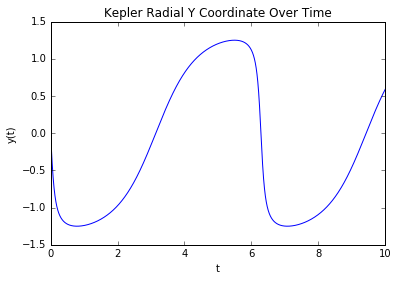

In [5]:
plot(t,y)
xlabel('t')
ylabel('y(t)')
title('Kepler Radial Y Coordinate Over Time')

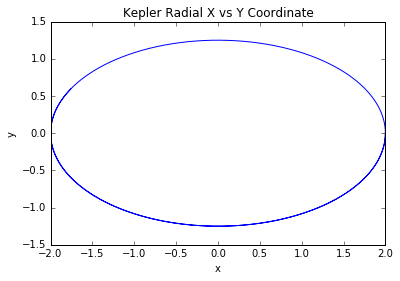

In [6]:
plot(x,y)
xlabel('x')
ylabel('y')
title('Kepler Radial X vs Y Coordinate')

The following outputs draw an expected elipticle shape for the orbit equation when converted to cartesian coordinates. The graph above of the objects x vs. y position does resemble planitary motion.